In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import find_duplicates
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.formula.api as smf

In [22]:
# set color blind friendly palette
sns.set_palette("colorblind") 

# Project Milestone 2

TODO: Abstract

TODO: Table of Contents:

____________________________

## Data Processing

### Loading the Data

In [23]:
# main data path and relative paths to the datasets
DATA_PATH = "data/"
DATA_PATH_MOVIESUMMARIES = DATA_PATH + "MovieSummaries/"
DATA_PATH_MOVIELENS = DATA_PATH + "MovieLens/"
DATA_PATH_IMDB = DATA_PATH + "IMDBData/"
DATA_PATH_FINANCIAL = DATA_PATH + "Financial/"

DATASET_PATH = {
    "movie_metadata": DATA_PATH_MOVIESUMMARIES + "movie.metadata.tsv",
    "movie_budget": DATA_PATH_MOVIELENS + "movies_metadata.csv",
    "imdb_ratings": DATA_PATH_IMDB + "title.ratings.tsv",
    "imdb_basics": DATA_PATH_IMDB + "title.basics.tsv",
    "cpi_data": DATA_PATH_FINANCIAL + "CPI.csv",
    "gdp_data": DATA_PATH_FINANCIAL + "GDP.csv",
}

DATASET_COLUMNS = {
    "movie_metadata": [
        "wikipedia_id",
        "freebase_movie_id",
        "title",
        "release_date",
        "revenue",
        "runtime",
        "languages",
        "countries",
        "genres",
    ],
    "movie_budget": [
        "budget",
        "imdb_id",
        "original_title",
        "popularity",
        "release_date",
        "revenue",
        "runtime",
        "title",
        "vote_average",
        "vote_count",
    ],
    "imdb_ratings": ["imdb_id", "imdb_rating", "num_votes"],
    "imdb_basics": [
        "imdb_id",
        "title_type",
        "primary_title",
        "title",
        "is_adult",
        "year",
        "end_year",
        "runtime",
        "genres",
    ],
}

In [24]:
# data types for the datasets
DATASET_TYPES = {
    "movie_metadata": {
        "wikipedia_id": "string",
        "freebase_movie_id": "string",
        "title": "string",
        "release_date": "string",
        "revenue": "float64",
        "runtime": "float64",
        "languages": "object",
        "countries": "object",
        "genres": "object",
    },
    "movie_budget": {
        "budget": "object",
        "imdb_id": "string",
        "original_title": "object",
        "popularity": "object",
        "release_date": "object",
        "revenue": "float64",
        "runtime": "float64",
        "title": "object",
        "vote_average": "float64",
        "vote_count": "float64",
    },
    "imdb_ratings": {
        "imdb_id": "string",
        "imdb_rating": "float64",
        "num_votes": "int64",
    },
    "imdb_basics": {
        "imdb_id": "string",
        "title_type": "string",
        "primary_title": "string",
        "title": "string",
        "is_adult": "string",
        "year": "string",
        "end_year": "string",
        "runtime": "string",
        "genres": "string",
    },
}

In [25]:
# load the datasets as pandas dataframes
movie_metadata = pd.read_csv(
    DATASET_PATH["movie_metadata"],
    sep="\t",
    names=DATASET_COLUMNS["movie_metadata"],
    index_col=False,
    header=None,
    dtype=DATASET_TYPES["movie_metadata"],
)
movie_budget = pd.read_csv(
    DATASET_PATH["movie_budget"],
    sep=",",
    usecols=DATASET_COLUMNS["movie_budget"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["movie_budget"],
)
imdb_ratings = pd.read_csv(
    DATASET_PATH["imdb_ratings"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_ratings"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_ratings"],
)
imdb_basics = pd.read_csv(
    DATASET_PATH["imdb_basics"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_basics"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_basics"],
)
cpi_data = pd.read_csv(
    DATASET_PATH["cpi_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)
gdp_data = pd.read_csv(
    DATASET_PATH["gdp_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)

In [26]:
# print the shapes of the datasets
print("Movie Metadata Shape: ", movie_metadata.shape)
print("MovieLens Budget Shape: ", movie_budget.shape)
print("IMDB Ratings Shape: ", imdb_ratings.shape)
print("IMDB Basics Shape: ", imdb_basics.shape)
print("CPI Data Shape: ", cpi_data.shape)
print("GDP Data Shape: ", gdp_data.shape)

Movie Metadata Shape:  (81741, 9)
MovieLens Budget Shape:  (45466, 10)
IMDB Ratings Shape:  (1368131, 3)
IMDB Basics Shape:  (10309011, 9)
CPI Data Shape:  (266, 68)
GDP Data Shape:  (266, 68)


### Data Handling

In this section we will clean and preprocess six datasets: `movie_metadata`, `movie_budget`, `imdb_ratings`, `imdb_basics`, `us_cpi`, and `us_gdp`, ensuring the removal of NaN values in order to prepare the data for accurate analysis. At the end we will have merged our six datasets into one single `movie` dataset, enriched with additional features gathered from each individual dataset.

##### Dataset: `movie_metadata`

The "CMU Movie Summary Corpus" provides an dataset of movie metadata containing 81,741 movies, extracted from the November 4, 2012 dump of Freebase. Every movie has details including movie box office revenue, genre, release date, runtime, and language.

In [27]:
display(movie_metadata)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [28]:
initial_movie_shape = movie_metadata.shape

print(
    "Total amount of rows that contain a NaN value: ",
    movie_metadata.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_metadata.isna().sum(),
        "nan_percentage": movie_metadata.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  73498


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_movie_id,0,0.000000
title,0,0.000000
release_date,6902,8.443743
revenue,73340,89.722416
runtime,20450,25.018045
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


We are mainly interested in the box office revenue, so we will drop all rows where this value is missing.
Additionally, we want to merge the CMU movies dataset with the IMDB dataset on title, year and runtime, so we need to drop the rows with missing values in these columns as well. Finally, we extract the year from the movie release date.

In [29]:
# drop all rows with missing values in the revenue, release_date or runtime column
movie_metadata = movie_metadata.dropna(subset=["revenue", "release_date", "runtime"])

# make a column year extracting the year from the release date
movie_metadata["year"] = movie_metadata["release_date"].str[:4]

We need to check for duplicates in order to only have unique movies in the dataset.

In [30]:
# see if there are any duplicates in the movie metadata dataset
find_duplicates(movie_metadata, ["title", "release_date", "runtime"])

"No duplicates found in the specified columns: ['title', 'release_date', 'runtime']"

In [31]:
print("Percentage of rows dropped after cleaning: ", ((1 - movie_metadata.shape[0]/initial_movie_shape[0]) * 100))

Percentage of rows dropped after cleaning:  89.91570937473239


Approximately 90% of the initial movie dataset was filtered out, resulting in a selection of 8,243 movies. This provides a sufficient basis for our intended analysis.


In [32]:
# the dataset after cleaning
display(movie_metadata)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999
...,...,...,...,...,...,...,...,...,...,...
81694,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",1997
81695,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",1988
81720,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",1990
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",2000


##### Dataset: `movie_budget`

We will use this external dataset to append the budget of the movies to our main movie dataset. This would help us to better understand the correlation between the budget and the revenue of the movies and explore the profitability of the movies.

In [33]:
display(movie_budget)

,budget,imdb_id,original_title,popularity,release_date,revenue,runtime,title,vote_average,vote_count
0,30000000,tt0114709,Toy Story,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0
1,65000000,tt0113497,Jumanji,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0
2,0,tt0113228,Grumpier Old Men,11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0
3,16000000,tt0114885,Waiting to Exhale,3.859495,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0
4,0,tt0113041,Father of the Bride Part II,8.387519,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...
45461,0,tt6209470,رگ خواب,0.072051,NaN,0.0,90.0,Subdue,4.0,1.0
45462,0,tt2028550,Siglo ng Pagluluwal,0.178241,2011-11-17,0.0,360.0,Century of Birthing,9.0,3.0
45463,0,tt0303758,Betrayal,0.903007,2003-08-01,0.0,90.0,Betrayal,3.8,6.0
45464,0,tt0008536,Satana likuyushchiy,0.003503,1917-10-21,0.0,87.0,Satan Triumphant,0.0,0.0


It is important to note that this dataset contains some budget values that are either zero or near-zero, which are realistically improbable. To maintain data integrity, these entries will be excluded from our analysis. According to [movieweb](https://movieweb.com/cheapest-movies-ever-made/#tarnation-218-32), an exceptional case in low-budget filmmaking is the documentary [Tarnation](https://en.wikipedia.org/wiki/Tarnation_(2003_film)) directed by Jonathan Caouette, with a budget of just \\$218.32. Consequently, we will exclude movies with reported budgets below \\$218 from our analysis, considering them likely to be inaccuracies or data entry errors. 

In [34]:
# the nans in this dataset are represented as "\\N" and <NAN>, so we need to replace them with NaN
movie_budget = movie_budget.replace("\\N", np.nan)
movie_budget = movie_budget.replace("<NAN>", np.nan)

# convert to float, non-convertible values become NaN
movie_budget["budget"] = pd.to_numeric(movie_budget["budget"], errors="coerce")

# replace budget values < $218 with NaN
movie_budget.loc[movie_budget["budget"] < 218, "budget"] = np.nan

print(
    "Total amount of rows that contain a NaN value: ",
    movie_budget.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_budget.isna().sum(),
        "nan_percentage": movie_budget.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  36772


,nan_sum,nan_percentage
budget,36758,80.847226
imdb_id,17,0.037391
original_title,0,0.000000
popularity,5,0.010997
release_date,87,0.191352
revenue,6,0.013197
runtime,263,0.578454
title,6,0.013197
vote_average,6,0.013197
vote_count,6,0.013197


We will be merging this dataset with the imdb datasets by imdb_id, so we drop all of the rows where this value is NaN. Additionally, we drop the columns that overlap with our initial movie_metadata dataset. Finally, since we are interested in populating the `movie_metadata` dataset with the budget, we drop all of the rows where this value is missing.

In [35]:
# drop all rows with missing value in the imdb_id column
movie_budget = movie_budget.dropna(subset=["imdb_id"])

# drop the columns which are present in movie_metadata
common_columns = movie_budget.columns.intersection(movie_metadata.columns)
movie_budget = movie_budget.drop(columns=common_columns)

# drop all rows with missing value in the budget column
movie_budget.dropna(subset=["budget"], inplace=True)

We need to check for duplicates in order to only have unique movies in the dataset.

In [36]:
# see if there are any duplicates in the movie budget dataset
find_duplicates(movie_budget, ["imdb_id"])

,budget,imdb_id,original_title,popularity,vote_average,vote_count
26625,10000000.0,tt0100361,The Phantom of the Opera,0.43849,5.0,3.0
9576,10000000.0,tt0100361,The Phantom of the Opera,0.441872,5.0,3.0
33743,26000000.0,tt0157472,Clockstoppers,4.920175,4.9,90.0
5130,26000000.0,tt0157472,Clockstoppers,5.373623,4.9,89.0
4114,16000000.0,tt0235679,Pokémon 3: The Movie,10.264597,6.0,143.0
44821,16000000.0,tt0235679,Pokémon 3: The Movie,6.480376,6.0,144.0
5865,30000000.0,tt0270288,Confessions of a Dangerous Mind,11.331072,6.6,281.0
33826,30000000.0,tt0270288,Confessions of a Dangerous Mind,7.645827,6.6,281.0
10419,1600000.0,tt0454792,Bubble,3.185256,6.4,36.0
12066,1600000.0,tt0454792,Bubble,3.008299,6.4,36.0


As we can see there are some movies that are present more than once, so we need to exclude them from the dataset.

In [37]:
# drop duplicates since there are some movies with the same imdb id
movie_budget = movie_budget.drop_duplicates(subset=["imdb_id"])

In [38]:
# the dataset after cleaning
display(movie_budget)

,budget,imdb_id,original_title,popularity,vote_average,vote_count
0,30000000.0,tt0114709,Toy Story,21.946943,7.7,5415.0
1,65000000.0,tt0113497,Jumanji,17.015539,6.9,2413.0
3,16000000.0,tt0114885,Waiting to Exhale,3.859495,6.1,34.0
5,60000000.0,tt0113277,Heat,17.924927,7.7,1886.0
6,58000000.0,tt0114319,Sabrina,6.677277,6.2,141.0
...,...,...,...,...,...,...
45402,2000000.0,tt3761706,Корпоратив,0.52437,3.5,4.0
45408,2000000.0,tt0417949,Марс,0.380933,5.0,2.0
45409,800000.0,tt0933361,Dikari,0.903061,5.8,6.0
45412,2000000.0,tt1718881,Про любоff,0.121844,4.0,3.0


##### Dataset: `imdb_basics`

The `imdb_basics`("title.basics.tsv.gz") dataset contains information about different types of movies and TV shows. This dataset is used as a connection between `movie_metadata` and `imdb_ratings dataset`.

In [39]:
display(imdb_basics)

,imdb_id,title_type,primary_title,title,is_adult,year,end_year,runtime,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10309006,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10309007,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10309008,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10309009,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


Convert all of the missing values to be the same format (NaN)

In [40]:
# the nans in this dataset are represented as "\\N" and <NAN>, so we need to replace them
imdb_basics = imdb_basics.replace("\\N", np.nan)
imdb_basics = imdb_basics.replace("<NAN>", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_basics.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": imdb_basics.isna().sum(),
        "nan_percentage": imdb_basics.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  10255916


,nan_sum,nan_percentage
imdb_id,0,0.000000
title_type,0,0.000000
primary_title,17,0.000165
title,17,0.000165
is_adult,1,0.000010
year,1381604,13.401906
end_year,10194381,98.888060
runtime,7203485,69.875617
genres,460237,4.464415


First, the invalid values (those that are not numerical) in the runtime column are converted to NaN. Next, we drop all rows with missing values in the title, year and runtime columns, since we are joining the `movie_metadata` on these keys later. Additionally we drop the column end year, since it has 98.8\\% missing values, and the genre column since it is already present in `movie_metadata`. 

In [41]:
# convert runtime to float so it matches runtime from movie_metadata, the non-convertable values in runtime to NaN
imdb_basics["runtime"] = pd.to_numeric(imdb_basics["runtime"], errors='coerce').astype(float)

# drop all rows with missing value in the title, year or runtime column
imdb_basics = imdb_basics.dropna(subset=["title", "year", "runtime"])

# drop the columns which are present in movie_metadata and column end_year since it is almost always NaN
imdb_basics = imdb_basics.drop(columns=["end_year", "genres"])

We need to check for duplicates in order to only have unique movies in the dataset.

In [42]:
find_duplicates(imdb_basics, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [43]:
display(imdb_basics)

,imdb_id,title_type,primary_title,title,is_adult,year,runtime
0,tt0000001,short,Carmencita,Carmencita,0,1894,1.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1.0
...,...,...,...,...,...,...,...
10308961,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013,49.0
10308967,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,43.0
10309002,tt9916840,tvEpisode,Horrid Henry's Comic Caper,Horrid Henry's Comic Caper,0,2014,11.0
10309009,tt9916856,short,The Wind,The Wind,0,2015,27.0


##### Dataset: `imdb_ratings`

This dataset will be used in order to enrich the `movie_metadata` with the movie ratings together with the number of votes.

In [44]:
display(imdb_ratings)

,imdb_id,imdb_rating,num_votes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2691
...,...,...,...
1368126,tt9916730,7.6,11
1368127,tt9916766,7.0,22
1368128,tt9916778,7.2,36
1368129,tt9916840,8.8,6


In [45]:
# the nans in this dataset (if any) are represented as "\\N" and <NAN>, so we need to replace them
imdb_ratings = imdb_ratings.replace("\\N", np.nan)
imdb_ratings = imdb_ratings.replace("<NAN>", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_ratings.isna().any(axis=1).sum(),
)

Total amount of rows that contain a NaN value:  0


We need to check for duplicates in order to only have unique movies in the dataset.

In [46]:
find_duplicates(imdb_ratings, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [47]:
display(imdb_ratings)

,imdb_id,imdb_rating,num_votes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2691
...,...,...,...
1368126,tt9916730,7.6,11
1368127,tt9916766,7.0,22
1368128,tt9916778,7.2,36
1368129,tt9916840,8.8,6


##### Dataset: `us_cpi`

Our analysis integrates the Consumer Price Index (CPI) data provided by Worldbank. We focus specifically on the CPI data for the United States, which aligns with our dataset's use of USD as the currency for budget and revenue.

In [48]:
# since revenue, budget are in USD we only need the inflation data for the US
us_cpi = cpi_data[cpi_data["Country Name"] == "United States"]

# keep only the "year" column, drop the rest
us_cpi = us_cpi[[col for col in us_cpi.columns if col.isdigit()]]

# drop columns with year > 2012, since we only need have movie data until 2012
us_cpi = us_cpi.drop(columns=us_cpi.columns[us_cpi.columns > "2012"])

# transpose the dataframe
us_cpi = us_cpi.transpose().reset_index()

# rename columns to year and cpi
us_cpi.columns = ["year", "cpi"]

In [49]:
display(us_cpi.head())

,year,cpi
0,1960,13.563061
1,1961,13.708284
2,1962,13.872615
3,1963,14.044590
4,1964,14.224207


##### Dataset: `us_gdp`

By analyzing the Gross Domestic Product (GDP) data, we aim to examine how cinema gross revenue trends align with changes in the global economy. Again, we focus specifically on the GDP data for the United States, which aligns with our dataset's use of USD as the currency for budget and revenue.

In [50]:
# since revenue, budget are in USD we only need the data for the US
us_gdp = gdp_data[gdp_data["Country Name"] == "United States"]

# keep only the "year" column, drop the rest
us_gdp = us_gdp[[col for col in us_gdp.columns if col.isdigit()]]

# drop columns with year > 2012
us_gdp = us_gdp.drop(columns=us_gdp.columns[us_gdp.columns > "2012"])

# transpose the dataframe
us_gdp = us_gdp.transpose().reset_index()

# rename columns to year and gdp
us_gdp.columns = ["year", "gdp"]

In [51]:
display(us_gdp.head())

,year,gdp
0,1960,5.433000e+11
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11


### Expanding and merging the data

Now that we have cleaned all of the data, we can enrich the initial movie dataset with the external datasets.

In enriching the movie dataset, we first merge `imdb_ratings` with `imdb_basics` to cover a wider range of movies, then combine this with `movie_budget`, and finally merge with the original dataset. This approach is preferred over directly merging `movie_budget` with `imdb_ratings` because the latter has a significantly larger movie count. Merging `movie_budget` directly with `imdb_ratings` would result in losing many ratings due to the lower number of movies in `movie_budget`. By using `imdb_basics`, which has more comprehensive movie data, we ensure maximum retention of movie ratings before adding budget information.

In [52]:
# merge the imdb datasets
imdb_dataset_temp = pd.merge(
    imdb_basics,                         
    imdb_ratings, 
    on="imdb_id", 
    how="left"
)

# enrich imdb dataset with movie budget data
imdb_dataset = pd.merge(
    imdb_dataset_temp,
    movie_budget,
    on="imdb_id",
    how="left",
)

display(imdb_dataset.head())

,imdb_id,title_type,primary_title,title,is_adult,year,runtime,imdb_rating,num_votes,budget,original_title,popularity,vote_average,vote_count
0,tt0000001,short,Carmencita,Carmencita,0,1894,1.0,5.7,2007.0,NaN,NaN,NaN,NaN,NaN
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5.0,5.8,269.0,NaN,NaN,NaN,NaN,NaN
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4.0,6.5,1909.0,NaN,NaN,NaN,NaN,NaN
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12.0,5.5,178.0,NaN,NaN,NaN,NaN,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1.0,6.2,2691.0,NaN,NaN,NaN,NaN,NaN


The resulting dataframe consists of many NaN values, but this is expected, since we merged a smaller dataset into a larger one.

Finally, we will merge the imdb_dataset containing the budget, with the `movie_metadata` dataset. We will do this by using the movie title, runtime, and release year as a key.

In [53]:
movies = pd.merge(
    movie_metadata,
    imdb_dataset,
    on=["title", "year", "runtime"],
    how="left",
)

display(movies.head(3))

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year,...,title_type,primary_title,is_adult,imdb_rating,num_votes,budget,original_title,popularity,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,0,4.9,56918.0,28000000.0,Ghosts of Mars,7.058599,4.8,299.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,movie,Alexander's Ragtime Band,0,6.8,2268.0,2000000.0,Alexander's Ragtime Band,0.632261,4.8,6.0
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,...,movie,Henry V,0,7.5,31200.0,9000000.0,Henry V,7.307967,7.4,73.0


### Inflation Adjusted Revenue and Budget According to CPI

The earliest year for CPI and GDP is 1960, so we drop all movies before 1960 

In [54]:
movies = movies[movies["year"] >= "1960"]

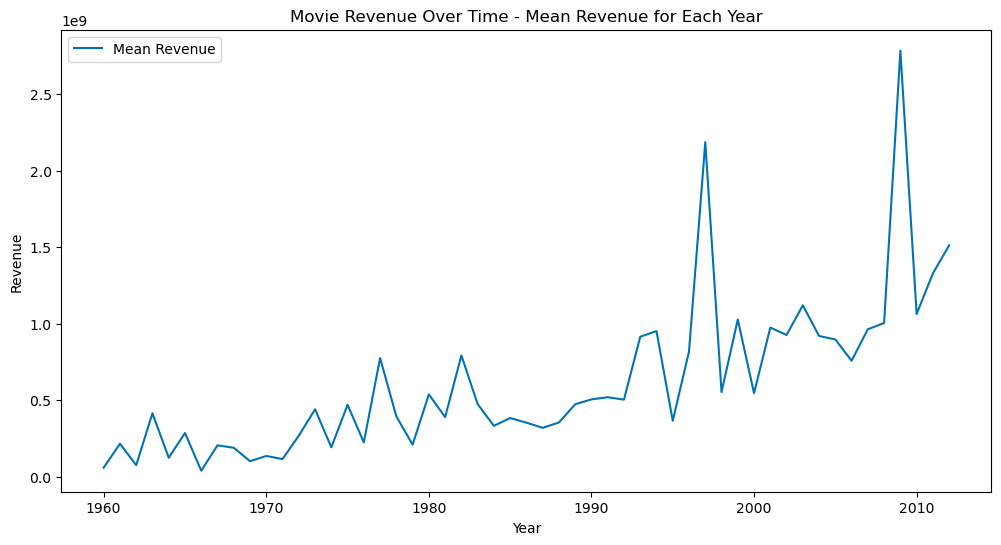

In [55]:
# plot the mean revenue for each year
mean_revenue = movies.groupby(pd.to_datetime(movies["year"]))[
    ["revenue"]
].max()

plt.figure(figsize=(12, 6))
plt.plot(mean_revenue.index, mean_revenue["revenue"], label="Mean Revenue")
plt.title("Movie Revenue Over Time - Mean Revenue for Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

As we can see, the mean revenue per year is increasing over time. To accurately compare movie revenues over time, we need to account for inflation. Without this adjustment, comparing movies from different eras becomes misleading. Older movies, which might have been very successful, will seem less profitable due to the lower ticket prices at their time.

The Consumer Price Index is calculated by measuring the price in one period for a fixed basket of consumer goods and services compared to previous periods.

- **Formula**: 
  $$ \text{Adjusted Value} = \left( \frac{\text{Current Value}}{\text{CPI in Current Year}} \right) \times \text{CPI Base Year} $$

- `Current Value`: The original revenue or budget of the movie.
- `CPI in Current Year`: The Consumer Price Index in the year the movie was released.
- `CPI Base Year`: The Consumer Price Index in the base year (2012).


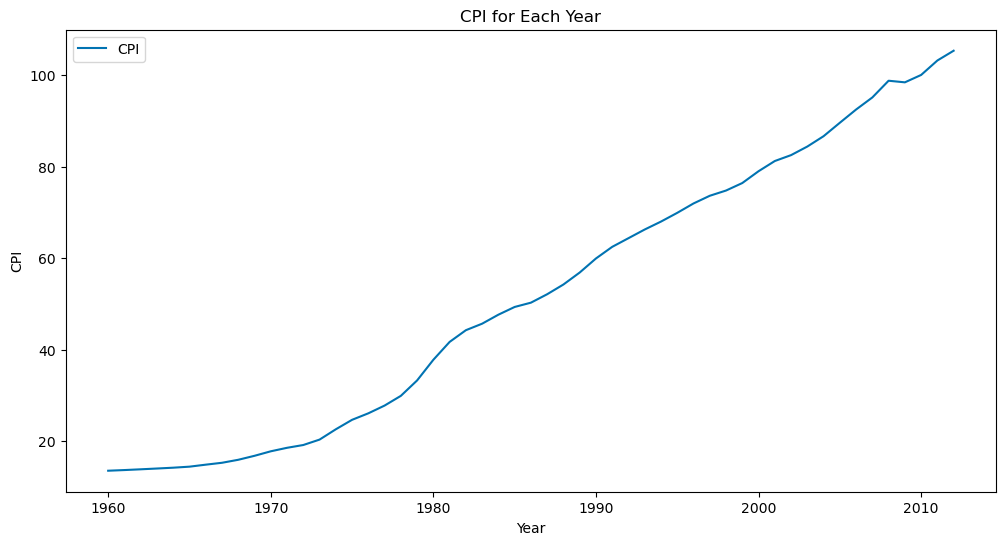

In [56]:
# plot the cpi for each year

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(us_cpi["year"]), us_cpi["cpi"], label="CPI")
plt.title("CPI for Each Year")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.legend()
plt.show()

The graph displays the Consumer Price Index (CPI) for each year, showing an upward trend from 1960 through until 2012.

We'll add two new columns to the dataset, one for the revenue adjusted for inflation and one for the budget adjusted for inflation.

In [57]:
# as our base year we choose 2012
cpi_base_year = us_cpi[us_cpi["year"] == "2012"]["cpi"].values[0]

# merge the movies dataset with the us_inflation dataset on the year column
movies = pd.merge(movies, us_cpi, on="year", how="left")

# calculate adjusted revenue and budget according to the formula
movies["revenue_adjusted"] = (
    movies["revenue"] / movies["cpi"]
) * cpi_base_year
movies["budget_adjusted"] = (
    movies["budget"] / movies["cpi"]
) * cpi_base_year

- When adjusted for inflation, how does the gross revenue of older movies compare to recent modern movies?

We'll plot the original revenue and the inflation-adjusted revenue over time, in order to see the difference.

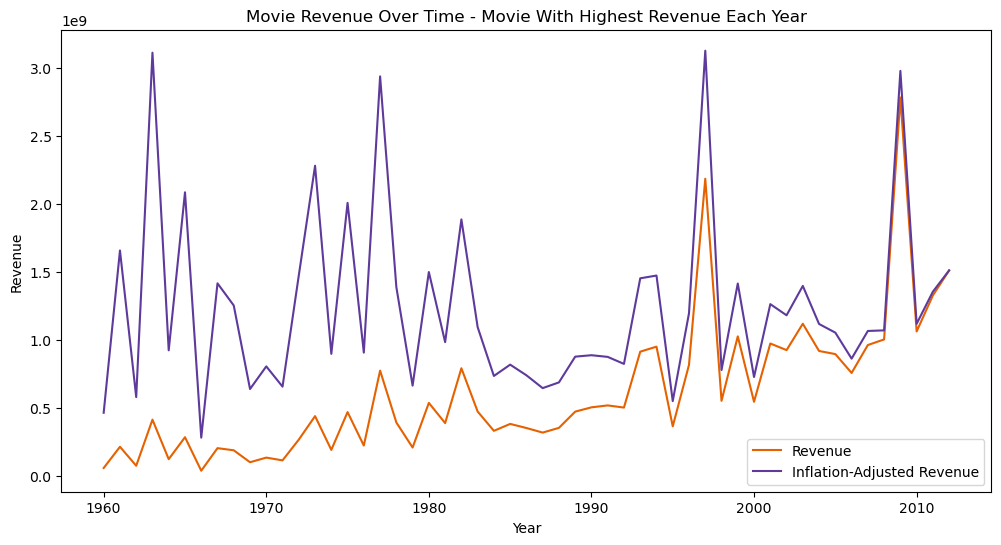

In [58]:
# group by year and get the movie with max revenue and revenue_inflation
annual_revenue = movies.groupby(pd.to_datetime(movies["year"]))[
    ["revenue", "revenue_adjusted"]
].max()

plt.figure(figsize=(12, 6))

plt.plot(
    annual_revenue.index, 
    annual_revenue["revenue"], 
    label="Revenue", 
    color = "#E66100",
)
plt.plot(
    annual_revenue.index,
    annual_revenue["revenue_adjusted"],
    label="Inflation-Adjusted Revenue",
    color = "#5D3A9B",
)

plt.title("Movie Revenue Over Time - Movie With Highest Revenue Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

From the plot we can see the revenues of the highest-grossing movie of each year with their inflation-adjusted equivalents. 
As we expected,  the inflation-adjusted revenues are higher than the reported revenues as the value of money decreases over time due to inflation. We can also see that the impact of inflation is more pronounced in earlier decades, as seen by the greater distance between the two lines.

After adjusting the revenue for inflation, the peaks in the revenue trends become more pronounced. We can see that some older movies actually have higher inflation-adjusted revenues than newer ones, which wouldn't be apparent if we only looked at nominal revenues.

In [59]:
top_movies = movies.sort_values(by=["revenue_adjusted"], ascending=False).head(5)
top_movies = top_movies[["title", "year", "revenue", "revenue_adjusted"]]
top_movies

,title,year,revenue,revenue_adjusted
1990,Titanic,1997,2.185372e+09,3.125832e+09
637,Love with the Proper Stranger,1963,4.150049e+08,3.111268e+09
2132,Avatar,2009,2.782275e+09,2.977544e+09
7103,Star Wars Episode IV: A New Hope,1977,7.753980e+08,2.937330e+09
2122,The Exorcist,1973,4.410710e+08,2.280793e+09


The movie with the highest nominal revenue is Avatar from 2009, with a revenue of approximately \\$ 2.782 billion. However, when we adjust for inflation, Titanic from 1997 shows a greater revenue than Avatar - an adjusted revenue of approximately \\$ 3.126 billion, compared to Avatar's adjusted revenue of about \\$ 2.978 billion.

Now we want to see if 'older' movies have a higher revenue than 'newer' movies. We define 'older' movies as movies that were released before 2000 and 'newer' movies as movies that were released after 2000.

In [60]:
old_movies_revenues = movies[movies["year"].astype(int) < 2000][
    "revenue_adjusted"
]
new_movies_revenues = movies[movies["year"].astype(int) >= 2000][
    "revenue_adjusted"
]

print("Number of movies before 2000: ", len(old_movies_revenues))
print("Number of movies after 2000: ", len(new_movies_revenues))

Number of movies before 2000:  3551
Number of movies after 2000:  3641


In order to determine this, we will perform a t-test. The null hypothesis is that there is no significant difference in mean revenues between older and newer movies, while the alternative hypothesis is that there is a significant difference. In this analysis, we will use a 0.05 level of significance. This means that if our p-value is less than 0.05, we will reject the null hypothesis and accept the alternative hypothesis.

In [61]:
mean_revenue_old = old_movies_revenues.mean()
mean_revenue_new = new_movies_revenues.mean()

# perform a t-test to see if the mean revenue of old movies is significantly higher than the mean revenue of new movies
t = ttest_ind(old_movies_revenues.values, new_movies_revenues.values)
print("Independent sample t-test: \n t =", t.statistic, "\n p =", t.pvalue)
print(
    "Mean revenue for older movies =",
    "{:.3f}".format(mean_revenue_old),
    "\nMean revenue for newer movies =",
    "{:.3f}".format(mean_revenue_new),
)

Independent sample t-test: 
 t = 3.066214880632238 
 p = 0.002175923717079693
Mean revenue for older movies = 89656715.404 
Mean revenue for newer movies = 76972127.711


The p-value of 0.0022 is less than 0.05, indicating that there is a statistically significant difference between the mean revenues of older movies (released before the year 2000) and newer movies (released in or after the year 2000). Given the mean revenues, we can conclude that older movies have a significantly higher mean revenue than newer movies when adjusted for inflation.

- Is there a correlation between the inflation adjusted budget and the release year of the movies?

We can plot the original budget and the inflation-adjusted budget over time, in order to see the difference.

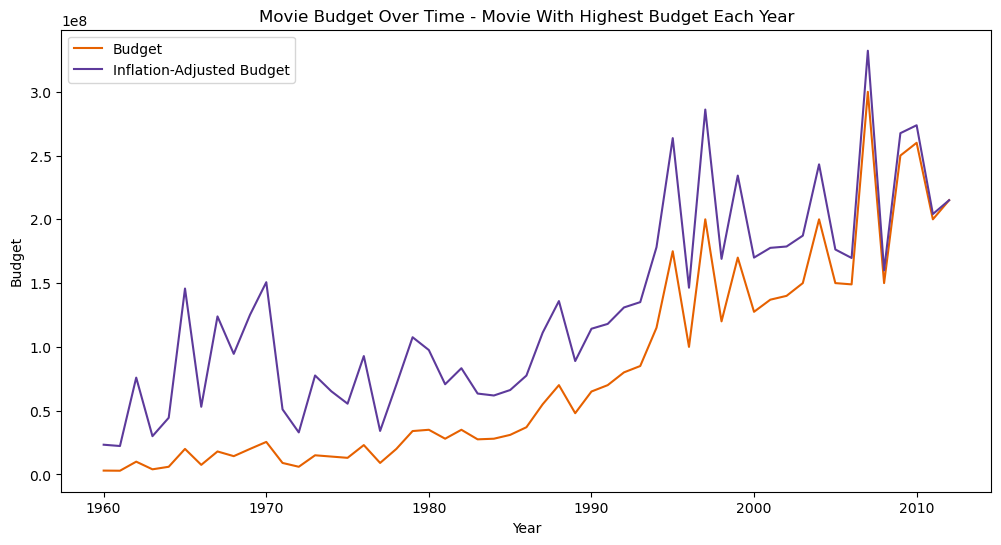

In [62]:
# group by year and get the movie with max budget and revenue_inflation
annual_revenue = movies.groupby(pd.to_datetime(movies["year"]))[
    ["budget", "budget_adjusted"]
].max()

plt.figure(figsize=(12, 6))

plt.plot(
    annual_revenue.index, 
    annual_revenue["budget"], 
    label="Budget", 
    color = "#E66100",
)

plt.plot(
    annual_revenue.index,
    annual_revenue["budget_adjusted"],
    label="Inflation-Adjusted Budget",
    color = "#5D3A9B",
)

plt.title("Movie Budget Over Time - Movie With Highest Budget Each Year")
plt.xlabel("Year")
plt.ylabel("Budget")
plt.legend()
plt.show()

Again as expected, the inflation-adjusted budgets are consistently higher than the nominal budgets, illustrating the impact of inflation over time. Both the nominal and inflation-adjusted budget lines show an overall upward trend, indicating that the budgets for the high-budget movies per year have been increasing over the decades.

We'll do a pearson correlation between the inflation-adjusted budget and year to see if there is actually a correlation between the two.

In [63]:
movies_with_budget = movies.dropna(subset=["budget_adjusted"])
pearson_corr_coefficient, p_value = stats.pearsonr(
    movies_with_budget["year"].astype(float),
    movies_with_budget["budget_adjusted"],
)

print(f"Pearson's correlation coefficient: {pearson_corr_coefficient}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: 0.13043034760366934
P-value: 4.633704347063562e-08


The weak positive correlation coefficient and the low p-value suggest a statistically significant, yet not strong, linear relationship between the movie's release year and its inflation-adjusted budget.

The overall upward trend in both nominal and inflation-adjusted movie budgets could be related to broader economic growth, such as increases in GDP. As the economy grows, the movie industry seems to grow with it. We will explore this in the following section.

### GDP Data ...

TODO: ***Is there a correlation between cinema revenue growth and world economic growth?***
- How does the increase in cinema gross revenue correlate with global economic growth indicators like the world's GDP?
- Are there regional differences in this correlation, and if so, which regions show a stronger relationship?


In [64]:
display(us_gdp.head())

,year,gdp
0,1960,5.433000e+11
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11


---

TODO: ***Which factors determine the movie's financial success?***
- Do movies with higher budgets produce higher revenues?
- How do runtime and genre impact a movie's revenue?


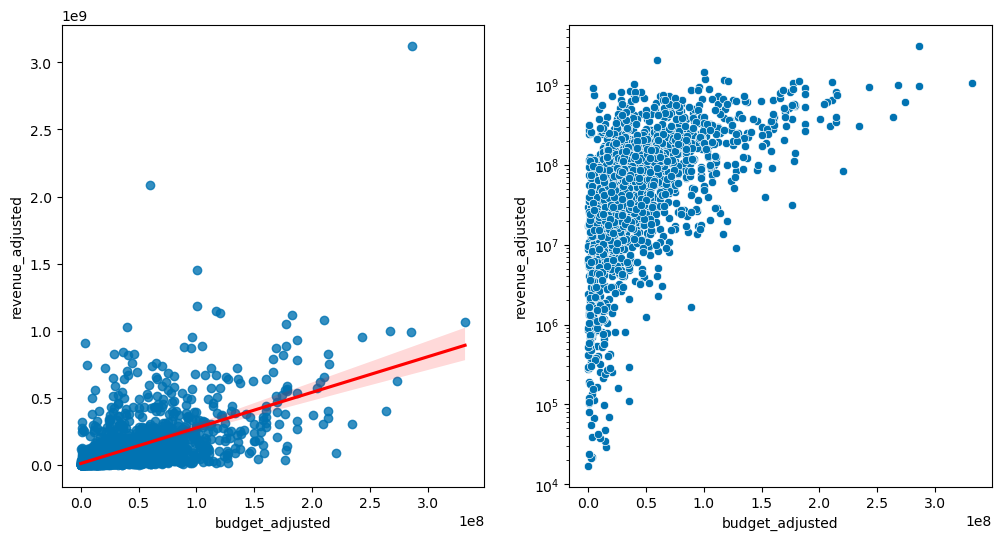

In [65]:
# plotting budget and revenue with a linear y scale (left) and log y scale (right)
# linear regression line is also shown on the left plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(
    ax=axes[0],
    data=movies_with_budget,
    x="budget_adjusted",
    y="revenue_adjusted",
    line_kws={"color": "red"},
)
sns.scatterplot(
    ax=axes[1],
    data=movies_with_budget,
    x="budget_adjusted",
    y="revenue_adjusted",
)
axes[1].set_yscale("log")
plt.show()

TODO: Comment on the plots

In [66]:
# check correlation between budget and revenue with pearson and spearman
print(
    "Pearson Correlation: ",
    stats.pearsonr(
        movies_with_budget["budget_adjusted"],
        movies_with_budget["revenue_adjusted"],
    ),
)
print(
    "Spearman Correlation: ",
    stats.spearmanr(
        movies_with_budget["budget_adjusted"],
        movies_with_budget["revenue_adjusted"],
    ),
)

Pearson Correlation:  PearsonRResult(statistic=0.5706510359479671, pvalue=3.74495474048541e-151)
Spearman Correlation:  SignificanceResult(statistic=0.6010321314073527, pvalue=1.1190326937062103e-171)


TODO: Comment on this

Which 5 movies made the most and the least profit? Could it happen that some movies even made a loss?

In [67]:
movies["profit"] = (
    movies["revenue_adjusted"] - movies["budget_adjusted"]
)
display(
    movies.sort_values(by=["profit"], ascending=False).head(5)[
        ["title", "year", "profit"]
    ]
)
print(
    "Number of movies that made profit: ",
    len(movies[movies["profit"] > 0]),
)
display(
    movies.sort_values(by=["profit"], ascending=True).head(5)[
        ["title", "year", "profit"]
    ]
)
print(
    "Number of movies that made loss: ", len(movies[movies["profit"] < 0])
)

,title,year,profit
1990,Titanic,1997,2.839764e+09
3876,The Sound of Music,1965,2.025826e+09
5540,Jurassic Park,1993,1.353630e+09
749,The Lord of the Rings: The Two Towers,2002,1.081178e+09
1185,Finding Nemo,2003,1.032297e+09


Number of movies that made profit:  1209


,title,year,profit
5293,The Alamo,2004,-1.448673e+08
3452,The 13th Warrior,1999,-1.354905e+08
4335,The Adventures of Pluto Nash,2002,-1.185783e+08
6693,Mars Needs Moms,2011,-1.133044e+08
2615,Town & Country,2001,-1.032495e+08


Number of movies that made loss:  527


TODO: Comment on the movies + Reference

Fun fact: The movies that lost money are called box office bombs!

Has the trend of profit changed over time? Should we expect to see more movies with higher profit in the future?

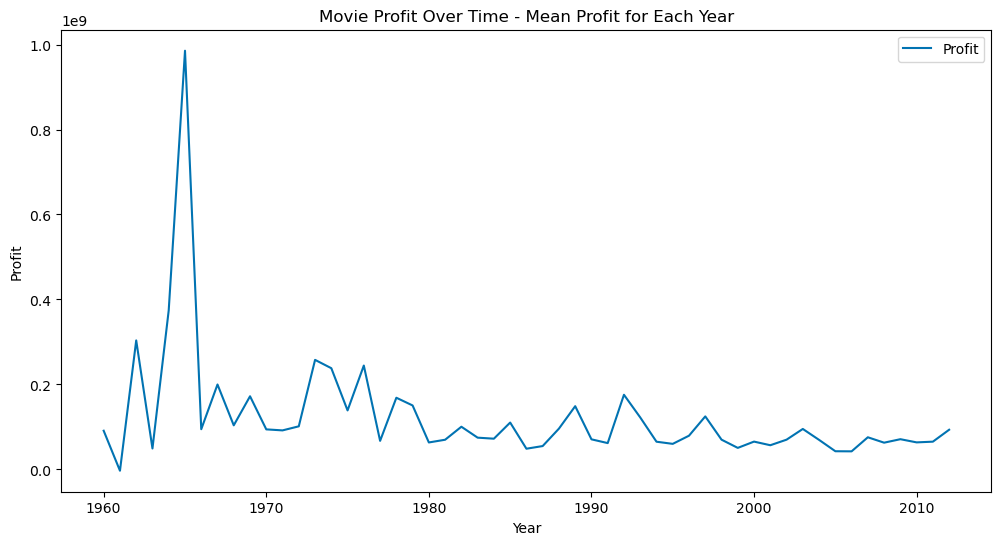

In [68]:
# plot the profit of movies over time
plt.figure(figsize=(12, 6))
plt.plot(
    movies.groupby(pd.to_datetime(movies["year"]))["profit"].mean(),
    label="Profit",
)
plt.title("Movie Profit Over Time - Mean Profit for Each Year")
plt.xlabel("Year")
plt.yscale("linear")
plt.ylabel("Profit")
plt.legend()
plt.show()

TODO: Comment on this. Comment on mean profit > 0 

In [69]:
# create a list storing the profit for each year
profit_per_year = []
for year in movies["year"].unique():
    profit_per_year.append(
        movies[movies["year"] == year]["profit"].mean()
    )

# year with the highest and lowest profit
print(
    "Year with highest profit: ",
    movies["year"].unique()[np.argmax(profit_per_year)],
)
print(
    "Year with lowest profit: ",
    movies["year"].unique()[np.argmin(profit_per_year)],
)

Year with highest profit:  1965
Year with lowest profit:  1961


Here we perform a one-way ANOVA test to check if the mean profit of movies is the same for all years. This would show whether there exists a significant difference in the mean profit of movies for different years.



In [70]:
print(stats.f_oneway(movies["year"].unique(), profit_per_year))
print(stats.spearmanr(movies["year"].unique(), profit_per_year))

F_onewayResult(statistic=40.90813182701674, pvalue=4.6351722914999435e-09)
SignificanceResult(statistic=-0.4546040961135301, pvalue=0.0006270072495625316)


We can see with the one way Anova test that the means are different for different years, so we can reject the null hypothesis. However, the statistic is small, so the difference is not very significant. Additionally, with the Spearman correlation test we can see that there is a weak negative correlation between the year and the profit. This means that the profit decreases over time, as can also be seen on the plot. We cannot clearly separate the factors that influence the decrease in profit, but following this trend we should expect that the profit will decrease in the future as well.

What were the chances of a movie making an outstanding profit in the past?

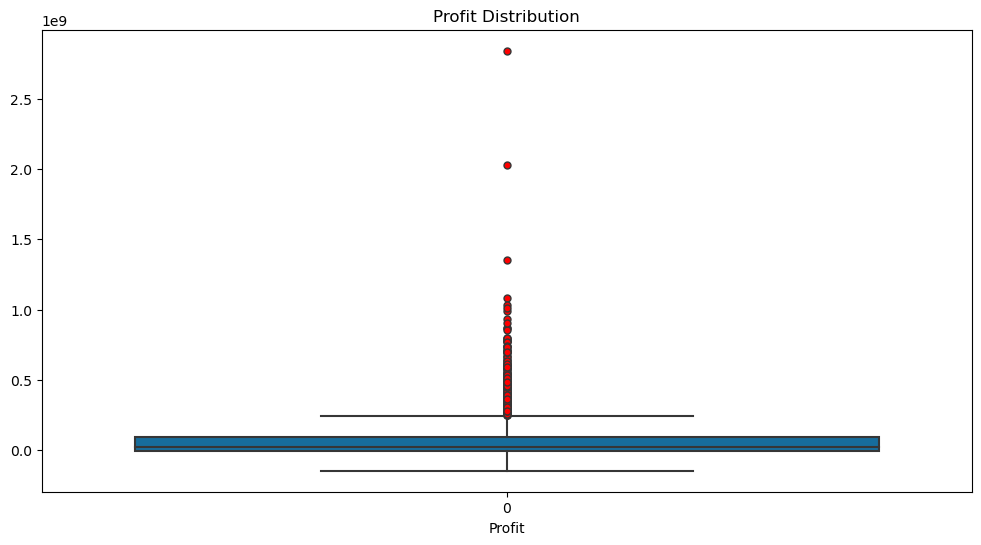

In [71]:
all_profits = movies[movies["budget"] > 0][["profit", "budget"]]
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=all_profits["profit"], flierprops=dict(markerfacecolor="r", marker="o")
)
plt.title("Profit Distribution")
plt.xlabel("Profit")
plt.yscale("linear")
plt.show()

TODO: Try to find a better plot!!!!!!!!!!!!!!!!!!!!!!!!!!! Idea is to find movies with above average profit (>95%)

We will try to briefly characterize the red dots (outliers) from the above boxplot.

In [73]:
# calculate the number of positive outliers in the boxplot distribution
q1 = all_profits["profit"].quantile(0.25)
q3 = all_profits["profit"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + (1.5 * iqr)
exceptional_profits = all_profits[all_profits["profit"] > upper_bound]
print("Number of movies with an exceptional profit: ", len(exceptional_profits))
# print chances of movie making exceptional profit formatted in %
print(
    "Chances of a movie making exceptional profit in the past: ",
    "{:.2f}".format(len(exceptional_profits) / len(all_profits) * 100),
    "%",
)

Number of movies with an exceptional profit:  171
Chances of a movie making exceptional profit in the past:  9.81 %


TODO: Maybe write a comment here, that this is not EXACLTY precise, but we assume that the data is equally representative of the ...

TODO: Comment that not everything is dependent on the profit/budget....

Furthermore, we want to analyze movies that had a high return on investment (ROI). These are the movies that had a high return on investment despite having a possibly low budget. Here are some differences in terms of representing profit and ROI: Scale: - Profit: real monetary amount gained or lost - ROI: percentage of the original investment that was gained or lost Direction: - Profit: positive or negative financial gain - ROI: positive or negative percentage of the original investment Interpretation: - Profit: straightforward absolute measure of financial success or failure in terms of dollars - ROI: relative measure of financial success or failure in terms of percentage of the original investment

In [74]:
# calculate ROI for movies with budget > 0
movies["roi"] = (
    movies["profit"] / movies["budget_adjusted"]
) * 100

# remove inf and NaN rows due to division of zero
movies = movies.replace([np.inf, -np.inf], np.nan)
movies = movies.dropna(subset=["roi"])

# identify top 5 movies with highest ROI
display(
    movies.sort_values(by=["roi"], ascending=False).head(5)[
        ["title", "year", "roi"]
    ]
)

,title,year,roi
3551,Night of the Living Dead,1968,36742.105263
4467,Mad Max,1979,24900.000000
1092,Halloween,1978,23233.333333
7027,Rocky,1976,22400.000000
5136,Joe,1970,18125.711321


We can see these movies are different from the ones that had the highest profit. They had a much lower budget, but a much higher ROI. This means that they had a much higher return on investment, despite having a lower budget.

In [75]:
# correlation between profit and roi
print(
    "Pearson Correlation: ",
    stats.pearsonr(movies["profit"], movies["roi"]),
)

Pearson Correlation:  PearsonRResult(statistic=0.23146281706390906, pvalue=1.246601857354523e-22)


TODO: Comment shortly why this is the case

### Which factors determine the movie's financial success?

#### Movie Runtime

What is the distribution of the movie runtime?

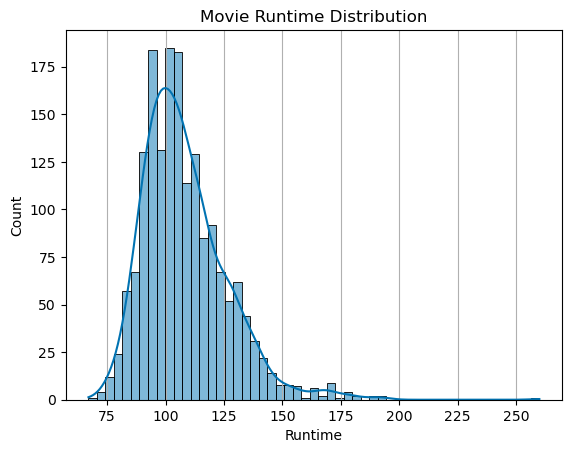

Average movie runtime (minutes):  108 ± 18


In [76]:
# runtime distribution histogram
sns.histplot( data=movies, x="runtime", bins='auto', kde=True)
plt.title("Movie Runtime Distribution")
plt.xlabel("Runtime")
plt.grid(axis="x")
plt.show()

print("Average movie runtime (minutes): ", round(movies["runtime"].mean()), u"\u00B1", round(movies["runtime"].std()))

Finding the relationship between budget, revenue and profit vs. runtime

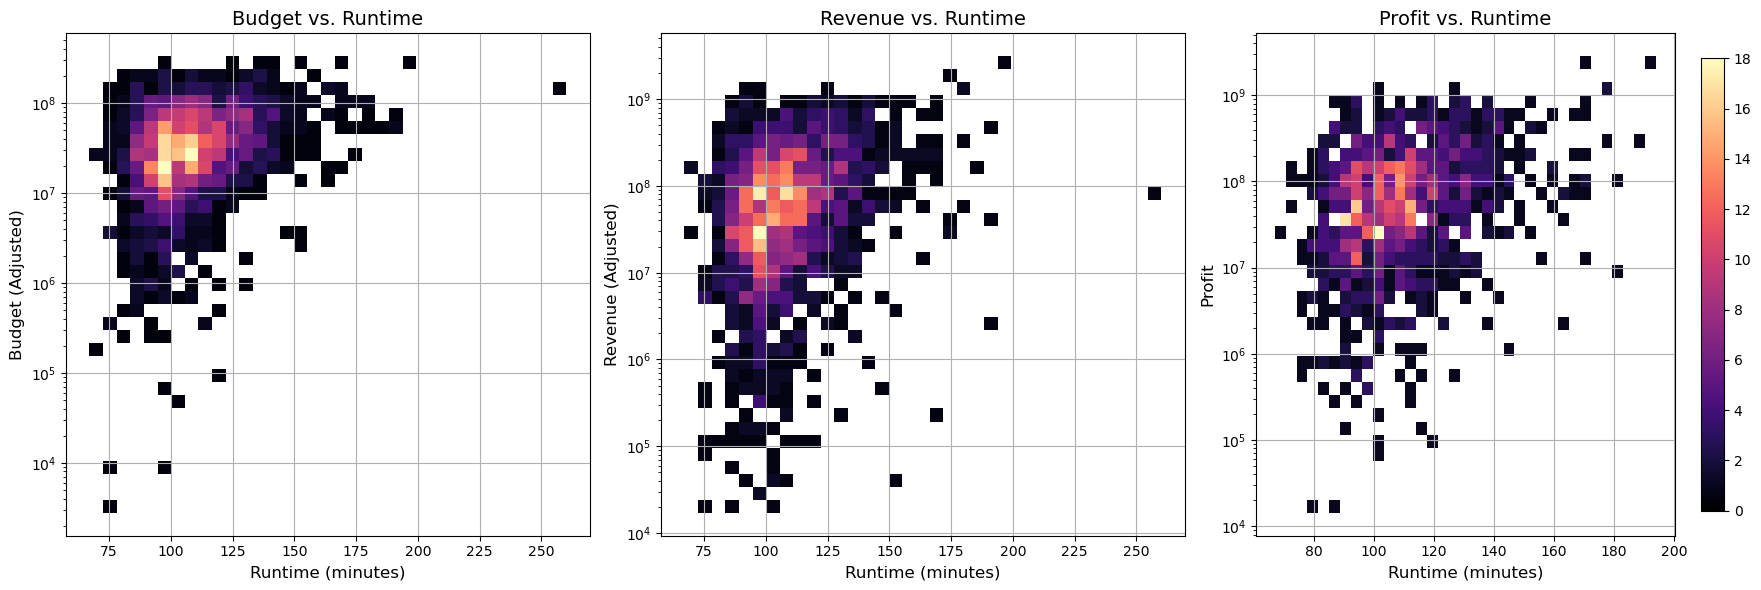

In [102]:
# plot budget, revenue and profit vs. runtime as 2d histograms with darker color where there are more points
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Budget vs. Runtime
sns.histplot(
    ax=axes[0],
    data=movies,
    x="runtime",
    y="budget_adjusted",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[0].set_title("Budget vs. Runtime", fontsize=14)
axes[0].set_xlabel("Runtime (minutes)", fontsize=12)
axes[0].set_ylabel("Budget (Adjusted)", fontsize=12)
axes[0].grid(True)

# Revenue vs. Runtime
sns.histplot(
    ax=axes[1],
    data=movies,
    x="runtime",
    y="revenue_adjusted",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[1].set_title("Revenue vs. Runtime", fontsize=14)
axes[1].set_xlabel("Runtime (minutes)", fontsize=12)
axes[1].set_ylabel("Revenue (Adjusted)", fontsize=12)
axes[1].grid(True)

# Profit vs. Runtime
sns.histplot(
    ax=axes[2],
    data=movies[movies["profit"] > 0],
    x="runtime",
    y="profit",
    bins=35,
    cbar=True,
    cbar_kws={"shrink": 0.9},
    cmap="magma",
    log_scale=(False, True),
)
axes[2].set_title("Profit vs. Runtime", fontsize=14)
axes[2].set_xlabel("Runtime (minutes)", fontsize=12)
axes[2].set_ylabel("Profit", fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()

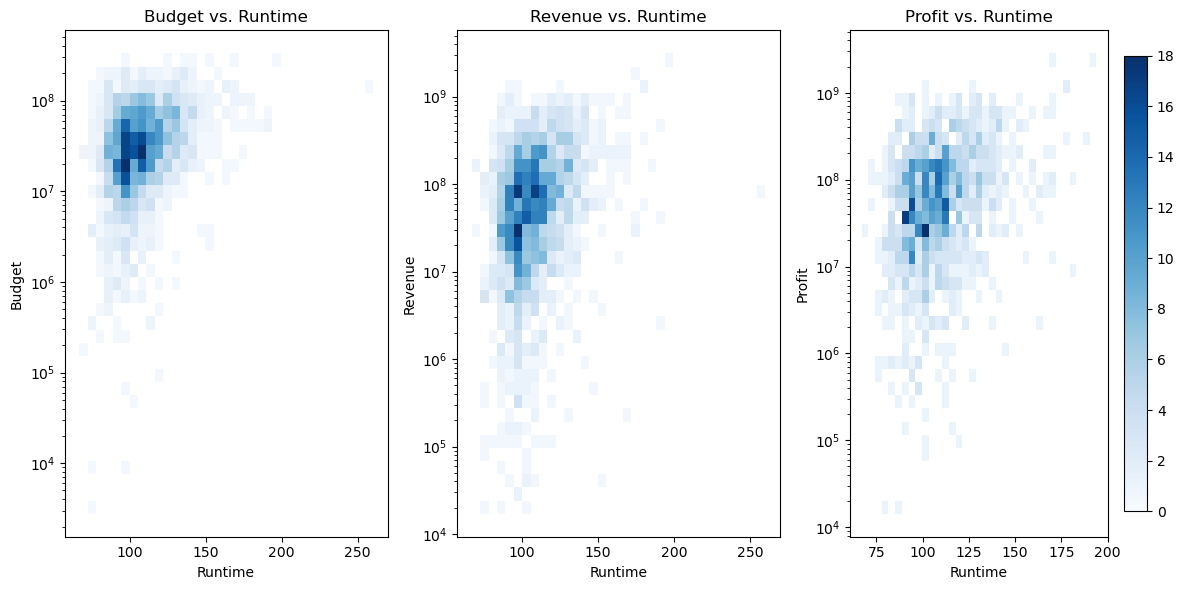

In [81]:
# plot budget, revenue and profit vs. runtime as 2d histograms with darker color where there are more points
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
sns.histplot(
    ax=axes[0],
    data=movies,
    x="runtime",
    y="budget_adjusted",
    bins=35,
    cmap="Blues",
    log_scale=(False, True),
)
sns.histplot(
    ax=axes[1],
    data=movies,
    x="runtime",
    y="revenue_adjusted",
    bins=35,
    cmap="Blues",
    log_scale=(False, True),
)
sns.histplot(
    ax=axes[2],
    data=movies[movies["profit"] > 0],
    x="runtime",
    y="profit",
    bins=35,
    cbar=True,
    cbar_kws={"shrink": 0.9},
    cmap="Blues",
    log_scale=(False, True),
)
axes[0].set_title("Budget vs. Runtime")
axes[0].set_xlabel("Runtime (minutes)")
axes[0].set_ylabel("Budget")
axes[1].set_title("Revenue vs. Runtime")
axes[1].set_xlabel("Runtime (minutes)")
axes[1].set_ylabel("Revenue")
axes[2].set_title("Profit vs. Runtime")
axes[2].set_xlabel("Runtime (minutes)")
axes[2].set_ylabel("Profit")
plt.tight_layout()
plt.show()

TODO: Comment on plots

In [103]:
# Spearmann correlation between runtime and budget, revenue and profit
print(
    "Spearman Correlation between runtime and budget: ",
    stats.spearmanr(movies["runtime"], movies["budget_adjusted"]),
)
print(
    "Spearman Correlation between runtime and revenue: ",
    stats.spearmanr(movies["runtime"], movies["revenue_adjusted"]),
)
print(
    "Spearman Correlation between runtime and profit: ",
    stats.spearmanr(movies["runtime"], movies["profit"]),
)

Spearman Correlation between runtime and budget:  SignificanceResult(statistic=0.31731757036107716, pvalue=4.5264092153197776e-42)
Spearman Correlation between runtime and revenue:  SignificanceResult(statistic=0.3013580071769405, pvalue=6.398004389404881e-38)
Spearman Correlation between runtime and profit:  SignificanceResult(statistic=0.20218302505785563, pvalue=1.5533541967716372e-17)


TODO: Comment on results (spearman because runtime is categorical)

<Axes: xlabel='runtime', ylabel='profit'>

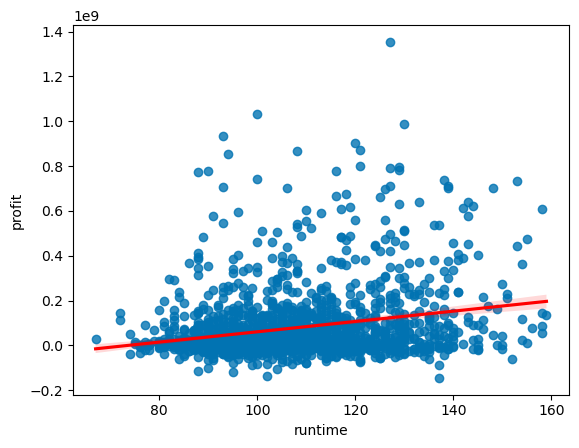

In [104]:
# scatter plot of runtime vs. profit
sns.regplot(
    data=movies[movies["runtime"] < 160],
    x="runtime",
    y="profit",
    ci=95,
    line_kws={"color": "red"},
)

Todo: Comment on line and how its not really interpretable

Todo: Comment on why we make a regression analysis

In [105]:
reg = smf.ols(
    formula="profit ~ runtime",
    data=movies,
).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     148.4
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           8.23e-33
Time:                        01:25:26   Log-Likelihood:                -35492.
No. Observations:                1743   AIC:                         7.099e+04
Df Residuals:                    1741   BIC:                         7.100e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.105e+08   2.44e+07     -8.645      0.0

Todo: Comment

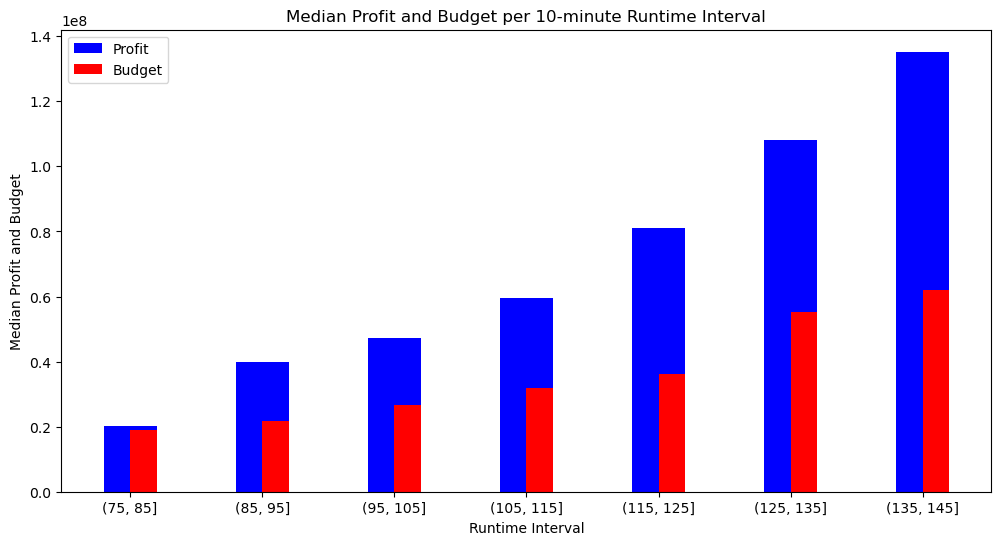

In [106]:
# median profit in 10 minute intervals
median_profit = movies[movies["profit"]>0].groupby(
    pd.cut(movies["runtime"], np.arange(75, 150, 10))
)["profit"].median()
median_budget = movies[movies["profit"]>0].groupby(
    pd.cut(movies["runtime"], np.arange(75, 150, 10))
)["budget_adjusted"].median()

# change the intervals to strings
median_profit.index = median_profit.index.astype(str)
median_budget.index = median_budget.index.astype(str)

# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    median_profit.index,
    median_profit,
    width=0.4,
    color="b",
    align="center",
    label="Profit",
)
ax.bar(
    median_budget.index,
    median_budget,
    width=0.2,
    color="r",
    align="edge",
    label="Budget",
)
ax.set_title("Median Profit and Budget per 10-minute Runtime Interval")
ax.set_xlabel("Runtime Interval")
ax.set_ylabel("Median Profit and Budget")
ax.legend()
plt.show()

TODO: Comment that profit increases linearly, but ROI is similar rate. Longer movie more money needed to produce it, but not necessarily more real ROI

In [108]:
# ROI per each runtime interval
movies[movies["profit"]>0].groupby(
    pd.cut(movies["runtime"], np.arange(75, 150, 10))
)["roi"].median()

runtime
(75, 85]      174.370796
(85, 95]      203.916069
(95, 105]     181.648533
(105, 115]    190.750000
(115, 125]    207.930453
(125, 135]    229.866680
(135, 145]    248.205995
Name: roi, dtype: float64